In [1]:
!git clone https://github.com/albertakn/Neural-Optimal-Transport-in-latent-space.git
%cd Neural-Optimal-Transport-in-latent-space/
!pip install -r requirements.txt

# Prepare vae weights and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp ../drive/MyDrive/diploma/v1-5-pruned-emaonly.ckpt data/ldm_weights/v1-5-pruned-emaonly.ckpt

Mounted at /content/drive


In [ ]:
!cp ../drive/MyDrive/YSDA/celeba256/archive.zip data/archive.zip
!unzip data/archive.zip -d data/
!rm data/archive.zip
!cp ../drive/MyDrive/YSDA/anime512/aligned_anime.zip data/aligned_anime.zip
!unzip data/aligned_anime.zip -d data/
!rm data/aligned_anime.zip

## Main Config

In [ ]:
DEVICE = 'cuda'
T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

ZC = 1
Z_STD = 0.1

BATCH_SIZE = 11
Z_SIZE = 8

PLOT_INTERVAL = 100
COST = 'weak_mse'
CPKT_INTERVAL = 300
MAX_STEPS = 100001


# Gamma will linearly increase from 0 to 0.66 during first 25k iters of the potential
GAMMA0, GAMMA1 = 0.0, 0.66
GAMMA_ITERS = 25000

## Prepare Samplers (X, Y)

In [ ]:
import torch
from torch.utils.data import DataLoader
from src.tools.dataset import FolderDataset


source_dataset = FolderDataset('data/celeba_hq_256', 512)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

target_dataset = FolderDataset('data/aligned_anime_faces/all', 512)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
iter_source, iter_target = iter(source_loader), iter(target_loader)
# iter_source, iter_target = None, None

def X_sampler():
    global iter_source, source_loader
    try:
        return next(iter_source)
        # return (torch.randn(BATCH_SIZE, 3, 64, 64), 10)
    except StopIteration:
        iter_source = iter(source_loader)
        return next(iter_source)

def Y_sampler():
    global iter_target, target_loader
    try:
        return next(iter_target)
        # return (torch.randn(BATCH_SIZE, 3, 64, 64), 10)
    except StopIteration:
        iter_target = iter(target_loader)
        return next(iter_target)

# Initializing Networks

In [ ]:
import numpy as np
from src.tools.utils import freeze, unfreeze
from src.NOT_models.resnet2 import ResNet_D
from src.NOT_models.unet import UNet

f = ResNet_D(IMG_SIZE, nc=4).to(DEVICE)

T = UNet(4+ZC, 4, base_factor=48).to(DEVICE)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716740
f params: 22934017


In [ ]:
from src.vae.model_loader import load_models_from_standard_weights

models = load_models_from_standard_weights('data/ldm_weights/v1-5-pruned-emaonly.ckpt', DEVICE)

print('encoder params:', sum([param.numel()for param in models['encoder'].parameters()]))
print('decoder params:', sum([param.numel()for param in models['decoder'].parameters()]))

freeze(models['encoder'])
freeze(models['decoder'])

encoder params: 34163664
decoder params: 49490199


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Tue Dec 26 16:09:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              34W /  70W |    677MiB / 15360MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
X = X_sampler()

with torch.no_grad():
    X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    X_test_fixed = models['decoder'](X_latent.to(DEVICE)).detach().cpu()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
Y = Y_sampler()

with torch.no_grad():
    Y_latent = models['encoder'](Y[0].to(DEVICE), Y[1].to(DEVICE)).detach().cpu()

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    Y_test_fixed = models['decoder'](Y_latent.to(DEVICE)).detach().cpu()
gc.collect()
torch.cuda.empty_cache()

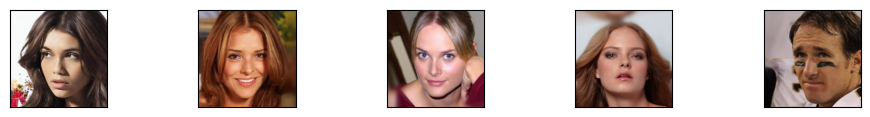

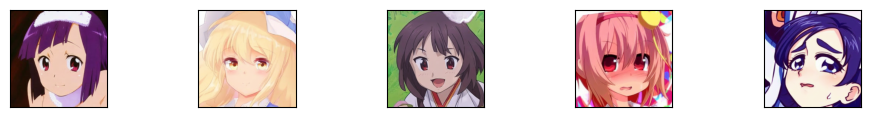

In [ ]:
from src.tools.plot import plot_original

plot_original(X_test_fixed)
plot_original(Y_test_fixed)

In [ ]:
with torch.no_grad():
    Z_test_fixed = torch.randn(BATCH_SIZE, 4, ZC, IMG_SIZE, IMG_SIZE, device='cpu') * Z_STD
    XZ_test_fixed = torch.cat([X_latent[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
X_latent.shape, Z_test_fixed.shape, XZ_test_fixed.shape

(torch.Size([11, 4, 64, 64]),
 torch.Size([11, 4, 1, 64, 64]),
 torch.Size([11, 4, 5, 64, 64]))

### Plots Test

<ipython-input-19-2ed7b2be53ab>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


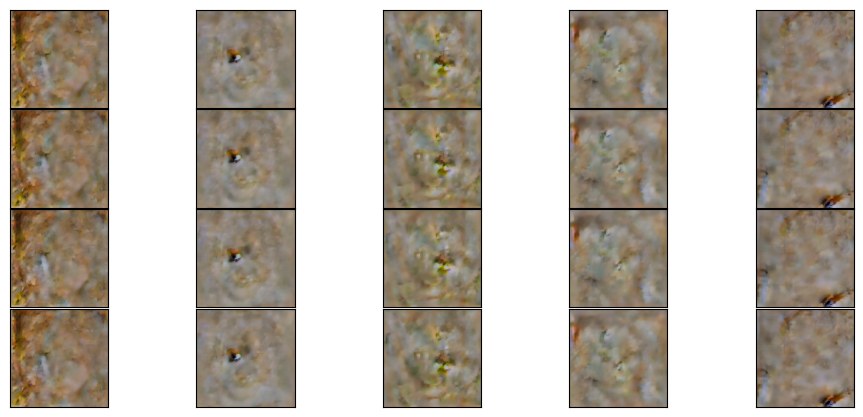

In [ ]:
from src.tools.plot import plot_many_images

with torch.no_grad():
    T_XZ_test_fixed = T(
        torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(4,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')
plot_many_images(T_XZ_test_fixed, models, DEVICE)

In [ ]:
T_XZ_test_fixed.shape

torch.Size([11, 4, 4, 64, 64])

In [ ]:
!nvidia-smi

Tue Dec 26 16:09:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              34W /  70W |    711MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Run Training

In [ ]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

<ipython-input-23-dd062d4645ed>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


Source images X, mapped images T(X, Z), unpaired target images Y


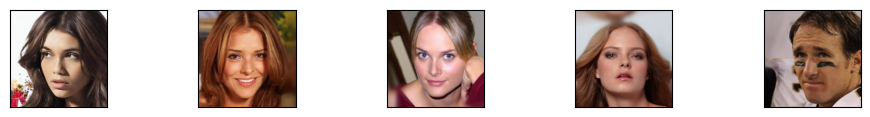

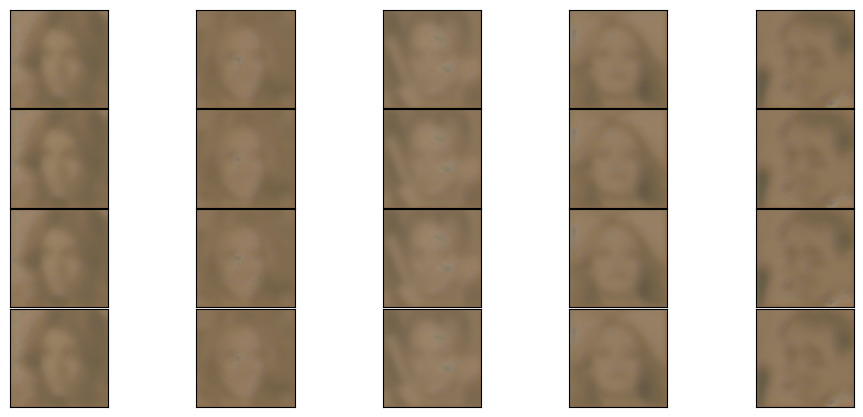

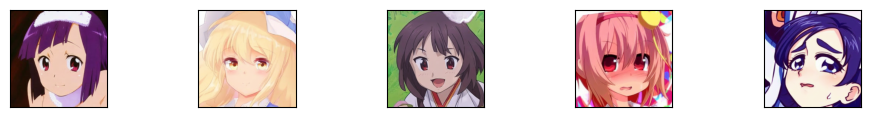

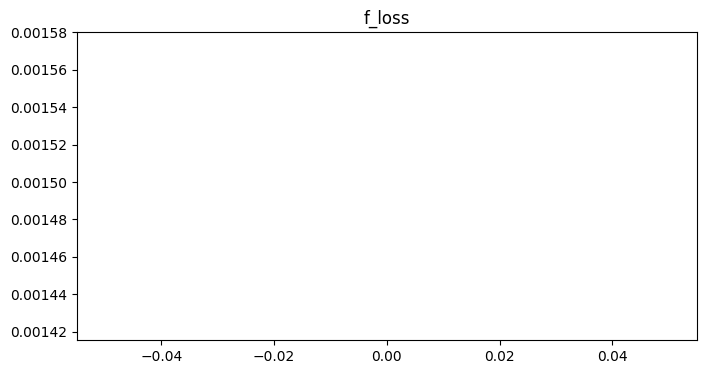

KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

f_loss_history = []
for step in tqdm(range(MAX_STEPS)):
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()

        X = X_sampler()
        with torch.no_grad():
            X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()
        gc.collect()
        torch.cuda.empty_cache()

        X = X_latent[:,None].repeat(1,Z_SIZE,1,1,1).to(DEVICE)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device=DEVICE) * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(4, IMG_SIZE, IMG_SIZE, BATCH_SIZE, Z_SIZE).permute(3,4,0,1,2)

        T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() + T_XZ.var(dim=1).mean() * (1 - gamma - 1. / Z_SIZE)

        T_loss.backward(); T_opt.step()
    del T_loss, T_XZ, X, Z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)

    X = X_sampler()
    with torch.no_grad():
        X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()
    gc.collect()
    torch.cuda.empty_cache()
    X = X_latent.to(DEVICE)

    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, X.size(2), X.size(3), device=DEVICE) * Z_STD
        XZ = torch.cat([X,Z], dim=1)
        T_XZ = T(XZ)


    Y = Y_sampler()
    with torch.no_grad():
        Y_latent = models['encoder'](Y[0].to(DEVICE), Y[1].to(DEVICE)).detach().cpu()
    gc.collect()
    torch.cuda.empty_cache()
    Y = Y_latent.to(DEVICE)


    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    f_loss_history.append(f_loss.detach().cpu().numpy())

    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        with torch.no_grad():
            T_XZ_test_fixed = T(
                torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
            ).permute(1,2,3,0).reshape(4,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')

        print('Source images X, mapped images T(X, Z), unpaired target images Y')
        plot_original(X_test_fixed)
        plot_many_images(T_XZ_test_fixed, models, DEVICE)
        plot_original(Y_test_fixed)
        plt.figure(figsize = (8, 4))
        plt.title('f_loss')
        plt.plot(f_loss_history)
        plt.show()

    if step % CPKT_INTERVAL == 0:
        torch.save({
            'epoch': step,
            'model_state_dict': f.state_dict(),
            'optimizer_state_dict': f_opt.state_dict(),
            }, 'VAE_f_checkpoint_newdataset.pth')

        torch.save({
            'epoch': step,
            'model_state_dict': T.state_dict(),
            'optimizer_state_dict': T_opt.state_dict(),
            }, 'VAE_T_checkpoint_newdataset.pth')
